<a href="https://www.kaggle.com/code/mahimomo/notebookeeb186f89e?scriptVersionId=296620011" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Global Cost of a Healthy Diet (2017–2024)

This notebook analyzes the global cost of a healthy diet between 2017 and 2024.

Aim is to:
- Understand global affordability trends
- Identify regional inequalities
- Detect countries where food costs are rising rapidly
- Examine instability and risk patterns in diet affordability

The analysis focuses on evidence-based insights rather than simple visualizations.



In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path("/kaggle/input/price-of-healthy-diet-clean/price_of_healthy_diet_clean.csv")

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
print(f"Loaded dataset: {DATA_PATH.name}")
print(f"Rows: {len(df)} and Columns : {df.shape[1]}")

Loaded dataset: price_of_healthy_diet_clean.csv
Rows: 1379 and Columns : 11


 ###  Data Overview


Each row represents one country in one year.  
The main variable of interest is the **daily cost of a healthy diet (PPP USD)**.


In [5]:
df.head(2)

,country_code,country,region,year,cost_healthy_diet_ppp_usd,annual_cost_healthy_diet_usd,cost_vegetables_ppp_usd,cost_fruits_ppp_usd,total_food_components_cost,cost_category,data_quality
0,8,Albania,Africa,2017,3.04,1109.60,NaN,NaN,NaN,High Cost,Estimated value
1,8,Albania,Africa,2018,3.13,1142.45,NaN,NaN,NaN,High Cost,Estimated value


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country_code                  1379 non-null   int64  
 1   country                       1379 non-null   object 
 2   region                        1379 non-null   object 
 3   year                          1379 non-null   int64  
 4   cost_healthy_diet_ppp_usd     1379 non-null   float64
 5   annual_cost_healthy_diet_usd  1379 non-null   float64
 6   cost_vegetables_ppp_usd       166 non-null    float64
 7   cost_fruits_ppp_usd           166 non-null    float64
 8   total_food_components_cost    166 non-null    float64
 9   cost_category                 1368 non-null   object 
 10  data_quality                  1379 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 118.6+ KB


## Data Coverage

The total cost of a healthy diet is available for all country-year pairs.  
However, fruit and vegetable component costs are available for only a small subset of records.  
Therefore, global conclusions rely on the total cost metric.


In [7]:
df.isnull().sum()

country_code                       0
country                            0
region                             0
year                               0
cost_healthy_diet_ppp_usd          0
annual_cost_healthy_diet_usd       0
cost_vegetables_ppp_usd         1213
cost_fruits_ppp_usd             1213
total_food_components_cost      1213
cost_category                     11
data_quality                       0
dtype: int64

**cost_vegetables_ppp_usd** : float64 (only 166 values)
   This is important,*Out of 1379 rows, only 166 have data.*
   That means: 88% of this column is missing.

   Same for: cost_fruits_ppp_usd and total_food_components_cost
   We will not consider these columns because the null values here are not something that can be imputed

We will handle minor missing category like cost_quality
   

### Data Cleaning and Type Fixes

In [8]:
numeric_cols_list = df.select_dtypes(include='number').columns.tolist()
print(f"Numeric columns are : {numeric_cols_list}")

Numeric columns are : ['country_code', 'year', 'cost_healthy_diet_ppp_usd', 'annual_cost_healthy_diet_usd', 'cost_vegetables_ppp_usd', 'cost_fruits_ppp_usd', 'total_food_components_cost']


In [9]:
for col in numeric_cols_list:
    df[col] = pd.to_numeric(df[col])

Fruit and vegetable costs are missing for most countries, so component-level analysis will be limited.

We will handle minor missing category like cost_quality

In [10]:
df["cost_category"] = df["cost_category"].fillna("unknown")

In [11]:
(df.isnull().mean()*100).sort_values(ascending=False)


total_food_components_cost      87.962292
cost_fruits_ppp_usd             87.962292
cost_vegetables_ppp_usd         87.962292
region                           0.000000
country                          0.000000
country_code                     0.000000
year                             0.000000
annual_cost_healthy_diet_usd     0.000000
cost_healthy_diet_ppp_usd        0.000000
cost_category                    0.000000
data_quality                     0.000000
dtype: float64

## Global Trend Over Time

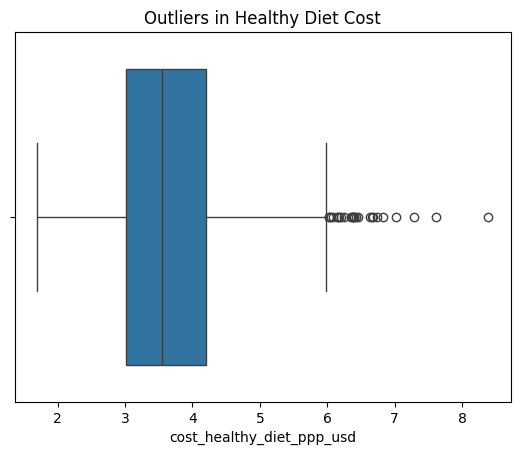

In [12]:
sns.boxplot(x =df["cost_healthy_diet_ppp_usd"])
plt.title("Outliers in Healthy Diet Cost")
plt.show()

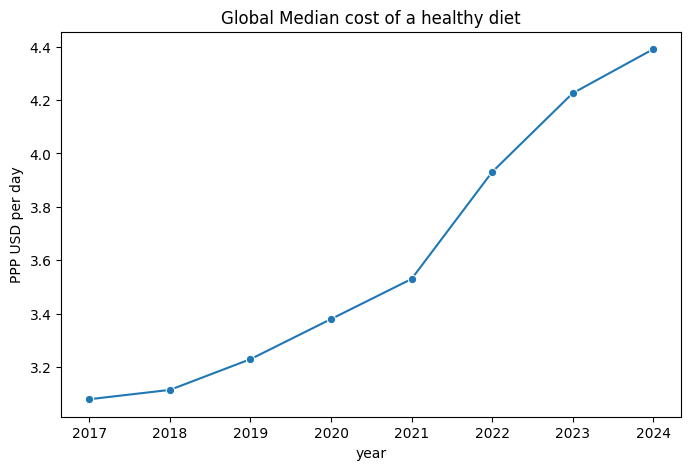

In [13]:
global_trend = df.groupby("year")["cost_healthy_diet_ppp_usd"].median()
plt.figure(figsize=(8,5))
sns.lineplot(x=global_trend.index, y =global_trend.values, marker= 'o')
plt.title("Global Median cost of a healthy diet")
plt.ylabel("PPP USD per day")
plt.show()

WHY MEDIAN?
Some countries are extremely expensive (outliers), median shows the typical country

We see, that Healthy diets are getting more expensive globally

## Regional Cost Levels & Inequality

In [14]:
df.groupby("region")["cost_healthy_diet_ppp_usd"].agg(["mean","std"]).sort_values("mean",ascending = False)

,mean,std
region,,
Africa,3.794130,0.798706
Americas,3.718942,1.003752
Asia,3.670125,0.888877
Europe,3.554670,0.890950


The **mean** shows the overall cost level of each region.  
The **standard deviation** shows how unequal countries are within the region.

Some regions show both high cost and high inequality.


<Axes: xlabel='region', ylabel='cost_healthy_diet_ppp_usd'>

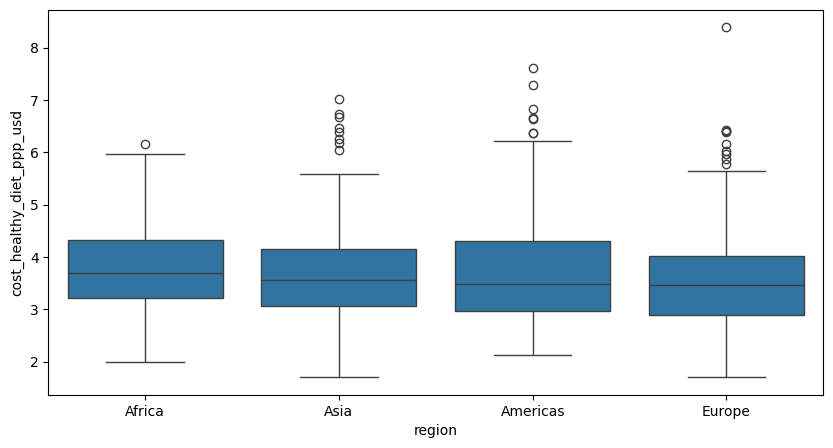

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="region",y ="cost_healthy_diet_ppp_usd")

Boxplots show the distribution of costs within each region.

Wide boxes and long whiskers indicate greater inequality in affordability among countries in the same region.
Outliers represent countries facing extreme diet costs.


## Countries with fastest cost increases

In [16]:
df = df.sort_values(["country","year"])
df["yoy_pct"]= df.groupby("country")["cost_healthy_diet_ppp_usd"].pct_change()*100
df.groupby("country")["yoy_pct"].mean().sort_values(ascending = False).head(5)

country
China, Taiwan Province of    23.750000
Lebanon                      22.586045
South Sudan                  16.647900
Syrian Arab Republic         13.831814
Sao Tome and Principe        10.539609
Name: yoy_pct, dtype: float64

## Top 10 countries with fastest cost growth

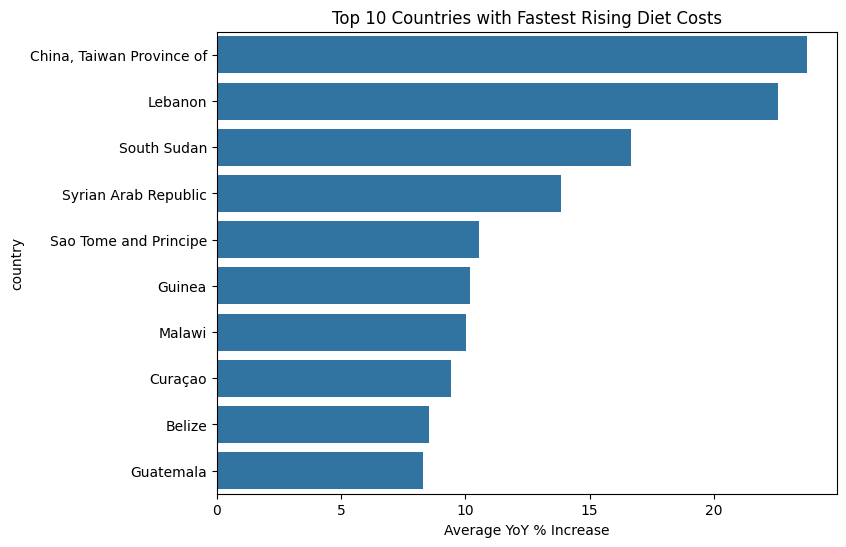

In [17]:
top_growth = df.groupby("country")["yoy_pct"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=top_growth.values, y=top_growth.index)
plt.title("Top 10 Countries with Fastest Rising Diet Costs")
plt.xlabel("Average YoY % Increase")
plt.show()


This identifies countries where diet affordability is deteriorating most rapidly.  
Rapid growth rates are early warning signals of future food access challenges.


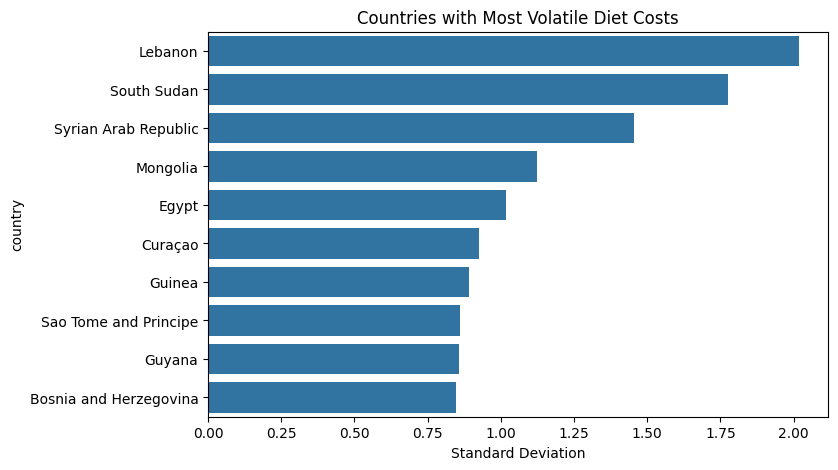

In [18]:
volatility = df.groupby("country")["cost_healthy_diet_ppp_usd"].std().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=volatility.values, y=volatility.index)
plt.title("Countries with Most Volatile Diet Costs")
plt.xlabel("Standard Deviation")
plt.show()


Volatility measures instability.  
Countries with highly fluctuating costs may face unpredictable affordability conditions.


## Correlation Between Cost Components

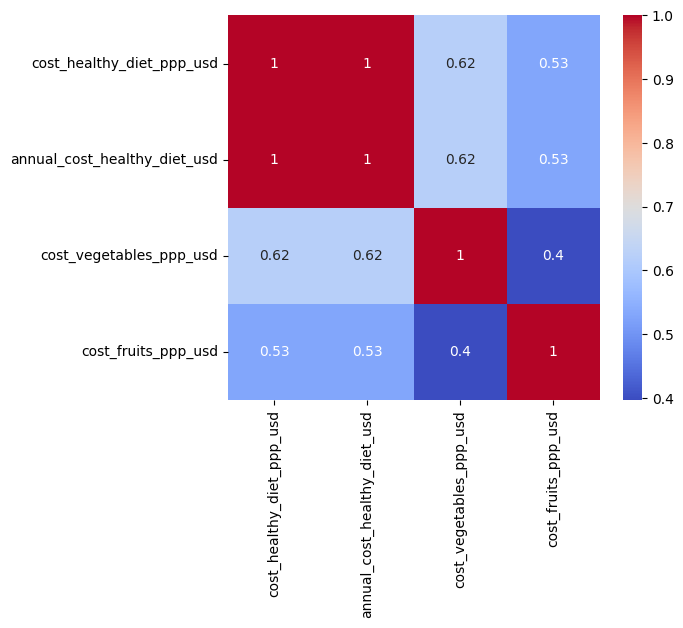

In [19]:
numeric_cols = [
    "cost_healthy_diet_ppp_usd",
    "annual_cost_healthy_diet_usd",
    "cost_vegetables_ppp_usd",
    "cost_fruits_ppp_usd"
]

plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.show()


Annual cost is perfectly correlated with daily cost (as expected).  
Fruit and vegetable costs show moderate correlation, meaning they contribute to overall cost but do not fully explain it.


## Shift in Risk Categories Over Time

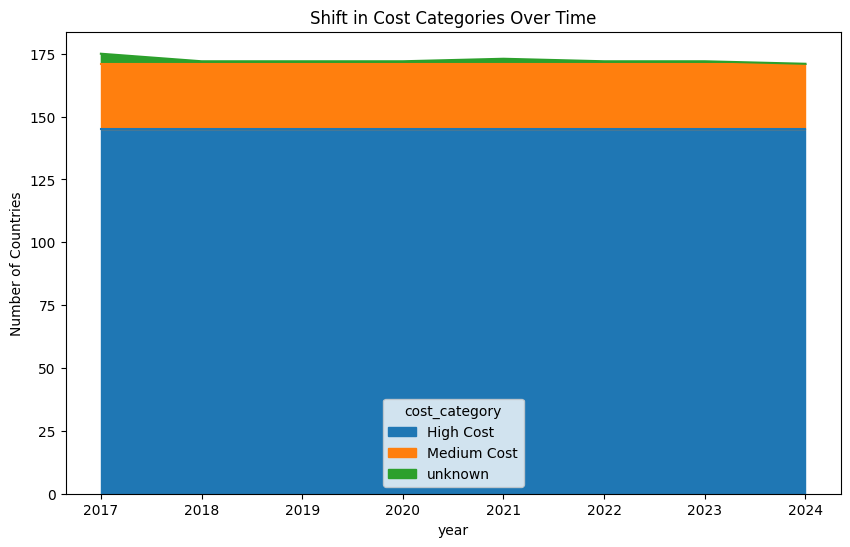

In [20]:
risk_shift = df.groupby(["year","cost_category"]).size().unstack()

risk_shift.plot(kind="area", stacked=True, figsize=(10,6))
plt.title("Shift in Cost Categories Over Time")
plt.ylabel("Number of Countries")
plt.show()


An increasing share of countries in higher cost categories suggests growing global affordability stress.


## Final Analysis

## Key Findings

- The global cost of a healthy diet has steadily increased since 2017
- Regional disparities in food affordability remain significant
- Some countries show rapid cost acceleration, indicating emerging risks
- Several countries experience high volatility in diet cost
- A subset of countries remains persistently high-cost over time
- Fruit and vegetable costs contribute to overall cost but are not the sole drivers

### Conclusion

Healthy diet affordability is deteriorating globally, with rising inequality and instability across countries. These trends highlight the need for targeted policy interventions to ensure access to nutritious food.
